# OCR with template matching using OpenCV

OpenCV offers to us the function `cv.matchTemplate`. This function allows us to OCR image, given  a set of image as template. For this example, we consider the characters from OCR-A font template, in specific, the digits from 0 to 9.

The goal is to extract the credit card numbers from image (toy images) and attribute the type of card as Visa, MasterCard, for example. To perform the OCR some techniques of image pre-processing will be applied. This example is based on the template from [PyImageSearch](https://www.pyimagesearch.com/2017/07/17/credit-card-ocr-with-opencv-and-python/).

## Importing Libraries

In [1]:
from imutils.contours import sort_contours
from imutils import paths
import numpy as np
import cv2 as cv
import imutils
import sys
import matplotlib.pyplot as plt

## Loading and pre-processing the template digits

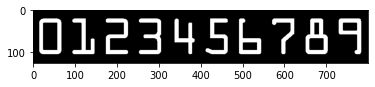

In [2]:
ref = cv.imread("ocr_a_reference.png")
ref = cv.cvtColor(ref, cv.COLOR_BGR2GRAY)
ref = cv.threshold(ref, 10, 255, cv.THRESH_BINARY_INV)[1]
plt.imshow(cv.cvtColor(ref, cv.COLOR_BGR2RGB))

**Extracting the contours and store them into a dictionary**

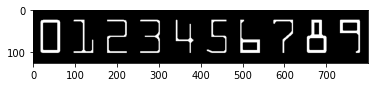

In [3]:
rcnts = cv.findContours(ref.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
rcnts = imutils.grab_contours(rcnts)
rcnts = sort_contours(rcnts, method='left-to-right')[0]
output = ref.copy()
cv.drawContours(output, rcnts, -1, (0, 0, 255), 3)
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))

**Intializing the dictionary map and extracting the digits from the image**

In [4]:
digits = {}

#loop over the digits
for (i, c) in enumerate(rcnts):
    
    #extracting the bound box of each contours
    (x, y, w, h) = cv.boundingRect(c)
    roi = ref[y : y + h, x : x + w]
    roi = cv.resize(roi, (57,88))
    #updating the digits dictionary
    digits[i] = roi

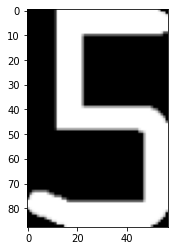

In [5]:
plt.imshow(cv.cvtColor(digits[5], cv.COLOR_BGR2RGB))

The dictionary `digits` contains the image template, once the region of interest is extracted on the image, we call this dictionary to apply the function `matchTemplate`.

## Loading the credit card images to be OCR'ed and pre-processing them


In [6]:
dataset = 'dataset/creditcard'
pathImages = list(paths.list_images(dataset))

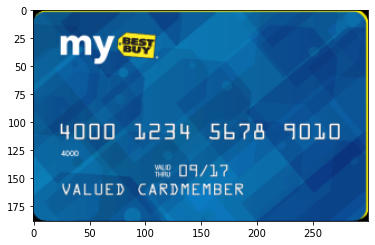

In [7]:
image = cv.imread(pathImages[0])
image = imutils.resize(image, width=300)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

**Image pre-processing**

- convert to gray
- Top Hat morphological operation
- Sobel Gradient
- Close morphological operation
- Image thresholding with Otsu method and binary operation

The kernel size used in this example differs from the PyImageSearch, testing the model, the best choice to obtain accurate results is $(13,5)$.

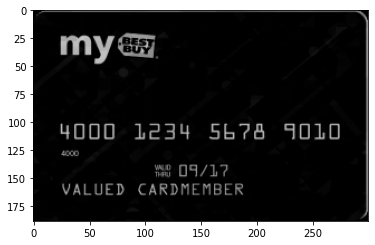

In [8]:
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
kernel = cv.getStructuringElement(cv.MORPH_RECT, (13,5))
tHat = cv.morphologyEx(gray, cv.MORPH_TOPHAT, kernel)
plt.imshow(cv.cvtColor(tHat, cv.COLOR_BGR2RGB))

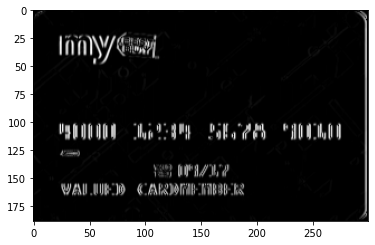

In [9]:
grad = cv.Sobel(tHat, ddepth = cv.CV_32F, dx = 1, dy = 0, ksize = -1)
grad = np.absolute(grad)
(minP,maxP) = (np.min(grad), np.max(grad))
grad = (grad - minP) / (maxP - minP)
grad = (grad * 255).astype('uint8')
plt.imshow(cv.cvtColor(grad, cv.COLOR_BGR2RGB))

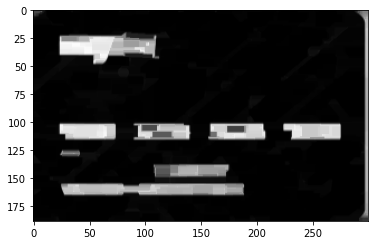

In [10]:
close = cv.morphologyEx(grad, cv.MORPH_CLOSE, kernel)
thresh = cv.threshold(close, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
plt.imshow(cv.cvtColor(close, cv.COLOR_BGR2RGB))

**Extracting the contours**

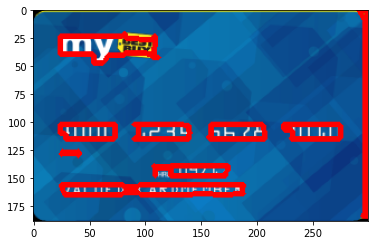

In [11]:
cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method='top-to-bottom')[0]
output = image.copy()
cv.drawContours(output, cnts, -1, (0, 0, 255), 3)
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))

**Selecting the contours corresponding to the credit card numbers**

Once we’ve grabbed the contours, we must select the contours corresponding to the credit card numbers. We start from the assumption that the four blocs of number are similar in respect to the aspect ratio and dimension. We can consider it due to the total number of character and their size.

In [12]:
locs = [] # empty list to store the digts location

In [13]:
for (i, c) in enumerate(cnts):
    (x, y, w, h) = cv.boundingRect(c)
    # calculate the aspect ratio of the bounding box
    ar = w / float(h)
    
    if ar > 2.5 and ar < 4.0:
        if (w > 40 and w < 70) and (h > 10 and h < 20):
            
            locs.append((x, y, w, h))
            

In [14]:
locs

[(224, 102, 52, 14), (157, 102, 51, 14), (90, 102, 51, 14), (24, 102, 50, 14)]

Now, we sort the list of the bound box location for each block of numbers.

In [15]:
locs = sorted(locs, key = lambda x:x[0])

In [16]:
locs

[(24, 102, 50, 14), (90, 102, 51, 14), (157, 102, 51, 14), (224, 102, 52, 14)]

In [17]:
output = [] # to store the credit card number

**Template Matching**

After the image pre-precessing, we had success to extract the four block region with the number. The last step is the template matching. To perform it, we consider a loop over each bound coordinates corresponding to a block. So we consider a numpy slice to obtain the image of the block. We extract the contours of each digit and create a correspondent image. Once we've extracted the digit, we call the function `cv.matchTemplate` to compare the current digit with the values inside the dictionary `digits`. The next step, we obtain the scores and select the highest.

Credit Card Type: Visa
Credit Card #: 4000123456789010


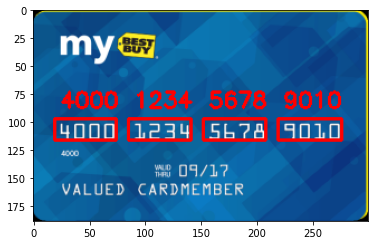

In [18]:
for i, (gX, gY, gW, gH) in enumerate(locs):
    
    groupOutput = []#list to store the charcter from the group
    
    group = gray[gY - 5: gY + gH, gX - 5: gX + gW]
    group = cv.threshold(group, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    
    #detecting the contour for each digits
    dcnts = cv.findContours(group.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    dcnts = imutils.grab_contours(dcnts)
    dcnts = sort_contours(dcnts, method='left-to-right')[0]
    
    # looping the contours and teplate-matching
    
    for c in dcnts:
        
        #bound box
        (x, y, w, h) = cv.boundingRect(c)
        roi = group[y : y + h, x : x + w]
        roi = cv.resize(roi, (57, 88))
        
        # list of template matching score
        scores = []
        
        for (digit, digitROI) in digits.items():
            ##apply the correlation tamplate matching
            
            result = cv.matchTemplate(roi, digitROI, cv.TM_CCOEFF)
            (_, score, _, _) = cv.minMaxLoc(result)
            scores.append(score)
    
        groupOutput.append(str(np.argmax(scores)))
        cv.rectangle(image, (gX - 5, gY - 5), (gX + gW, gY + gH), (0, 0, 255), 2)
        cv.putText(image, "".join(groupOutput), (gX, gY - 15), cv.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
    output.extend(groupOutput)

FIRST_NUMBER = {
"3": "American Express",
"4": "Visa",
"5": "MasterCard",
"6": "Discover Card"
}

    
# determine the card type
cardType = FIRST_NUMBER.get(output[0], "Unknown")
# display the output credit card information to the screen
print("Credit Card Type: {}".format(cardType))
print("Credit Card #: {}".format("".join(output)))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

## OCR'ing multiples images

Credit Card Type: Visa
Credit Card #: 4000123456789010


Credit Card Type: MasterCard
Credit Card #: 5412751234567890


Credit Card Type: Visa
Credit Card #: 4020340002345678


Credit Card Type: Visa
Credit Card #: 4000123456789010


Credit Card Type: MasterCard
Credit Card #: 5476767898765432




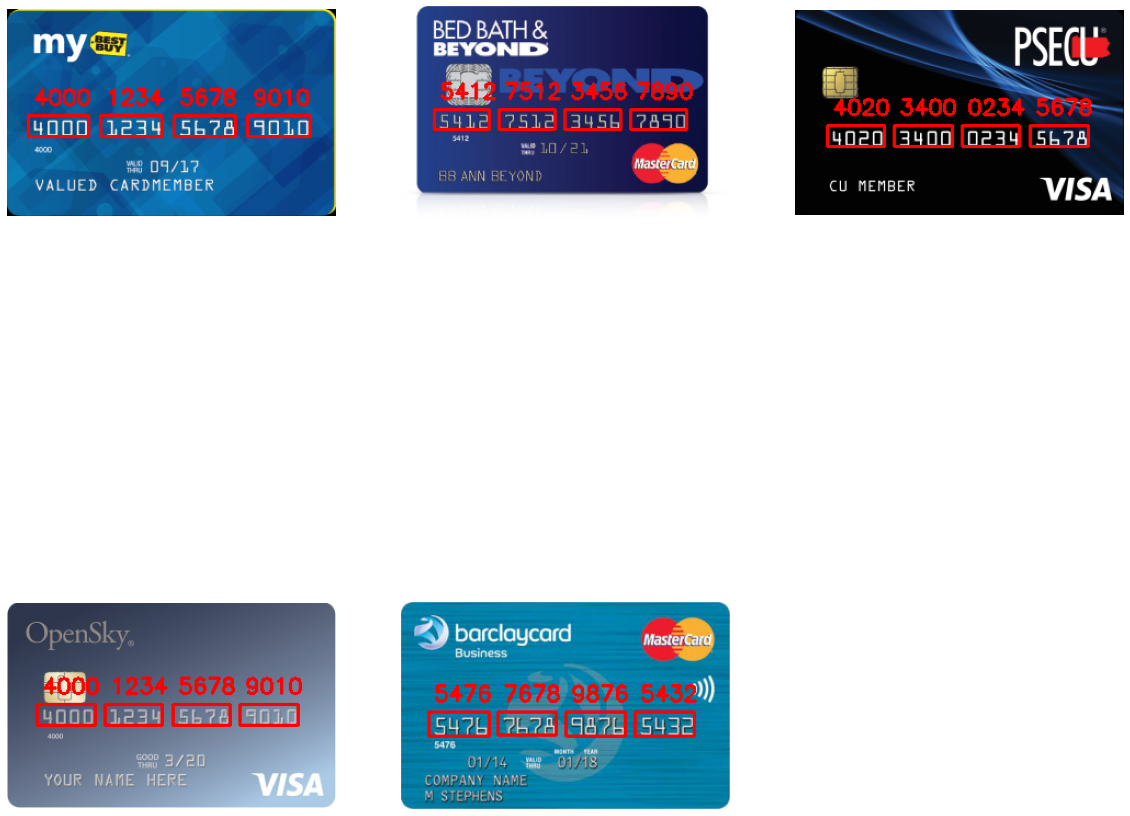

In [19]:
plt.figure(figsize=(20,20))
count = 1
for i in pathImages:
    #reading and resizing the image
    image = cv.imread(i)
    image = imutils.resize(image, width=300)
    #gray scale and top hat
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (13,5))
    tHat = cv.morphologyEx(gray, cv.MORPH_TOPHAT, kernel)
    #gradient
    grad = cv.Sobel(tHat, ddepth = cv.CV_32F, dx = 1, dy = 0, ksize = -1)
    grad = np.absolute(grad)
    (minP,maxP) = (np.min(grad), np.max(grad))
    grad = (grad - minP) / (maxP - minP)
    grad = (grad * 255).astype('uint8')
    #close morphological operation and image thresholding
    close = cv.morphologyEx(grad, cv.MORPH_CLOSE, kernel)
    thresh = cv.threshold(close, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    #finding contours
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method='top-to-bottom')[0]
    # empty list to store the digts location
    locs = []
    #selecting the contours
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv.boundingRect(c)
        # calculate the aspect ratio of the bounding box
        ar = w / float(h)

        if ar > 2.5 and ar < 4.0:
            if (w > 40 and w < 55) and (h > 10 and h < 20):

                locs.append((x, y, w, h))
    #sorting the locs list
    locs = sorted(locs, key = lambda x:x[0])
    # to store the credit card number
    output = []
    for i, (gX, gY, gW, gH) in enumerate(locs):
    
        groupOutput = []#list to store the charcter from the group

        group = gray[gY - 5: gY + gH, gX - 5: gX + gW]
        group = cv.threshold(group, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

        #detecting the contour for each digits
        dcnts = cv.findContours(group.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        dcnts = imutils.grab_contours(dcnts)
        dcnts = sort_contours(dcnts, method='left-to-right')[0]

        # looping the contours and teplate-matching

        for c in dcnts:

            #bound box
            (x, y, w, h) = cv.boundingRect(c)
            roi = group[y : y + h, x : x + w]
            roi = cv.resize(roi, (57, 88))

            # list of template matching score
            scores = []

            for (digit, digitROI) in digits.items():
                ##apply the correlation tamplate matching

                result = cv.matchTemplate(roi, digitROI, cv.TM_CCOEFF)
                (_, score, _, _) = cv.minMaxLoc(result)
                scores.append(score)

            groupOutput.append(str(np.argmax(scores)))
            cv.rectangle(image, (gX - 5, gY - 5), (gX + gW, gY + gH), (0, 0, 255), 2)
            cv.putText(image, "".join(groupOutput), (gX, gY - 15), cv.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)
        output.extend(groupOutput)
    
    cardType = FIRST_NUMBER.get(output[0], "Unknown")
    # display the output credit card information to the screen
    print("Credit Card Type: {}".format(cardType))
    print("Credit Card #: {}".format("".join(output)))
    print('\n')
        
    ax = plt.subplot(2,3,count)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')
    count += 1
plt.show()

## Conclusion

OCR with template-matching using OpenCV, in this example worked well. The results are $100\%$ correct. The image pre-processing plays a fundamental role in the results, it's thanks this step we are able to extract the region of interest, the block of numbers. On the other hand, this approach has your limitations, we can consider the images as “toy images”. In the real-world problem, we must consider different techniques, as machine learning and deep learning (NLP and Computer Vision).